# $\tau-p$ Transform
This notebook performs $\tau-p$ transformation to a real .segy data.

In [11]:
# imports
import segyio
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

## Synthetic data example
We first use a synthetic data to intuitively see what happens if we perform $\tau-p$ transform.

### Generate data

In [30]:
# 空间和时间采样

Nx = 50
Nt = 400

dx = 10.0      # m
dt = 0.004     # s

x = np.arange(Nx) * dx
t = np.arange(Nt) * dt

# 构造两个平面波

def ricker(t, f0=20):
    return (1 - 2*(np.pi*f0*t)**2) * np.exp(-(np.pi*f0*t)**2)

## 两个事件的参数
events = [
    {"p": 0.0005, "tau": 0.4, "amp": 1.0},
    {"p": 0.0010, "tau": 0.7, "amp": 0.8},
]

## 构造 f(x,t)
synthetic_data = np.zeros((Nx, Nt))

for ev in events:
    for ix in range(Nx):
        synthetic_data[ix] += ev["amp"] * ricker(
            t - (ev["tau"] + ev["p"] * x[ix])
        )

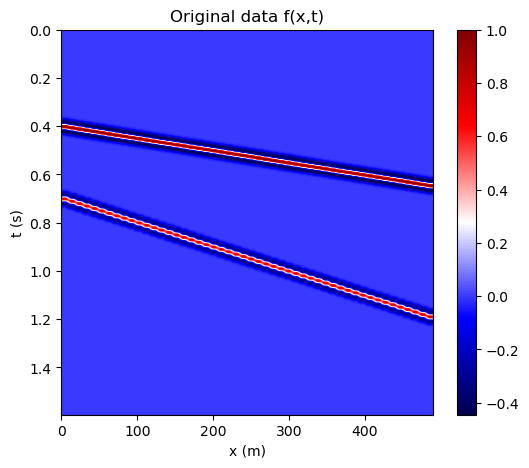

In [31]:
# visualize the synthetic data
plt.figure(figsize=(6,5))
plt.imshow(
    synthetic_data.T,
    extent=[x[0], x[-1], t[-1], t[0]],
    aspect='auto',
    cmap='seismic'
)
plt.xlabel("x (m)")
plt.ylabel("t (s)")
plt.title("Original data f(x,t)")
plt.colorbar()
plt.show()

### $\tau-p$ transform

Discrete $\tau-p$ transform: 
$$D(\tau,p)=\sum_{x} f(x,\tau+ px)$$

In [33]:
p_vals = np.linspace(0.0002, 0.0015, 80)
tau_vals = np.linspace(0.2, 1.0, 200)

tau_p = np.zeros((len(p_vals), len(tau_vals)))

for ip, p in enumerate(p_vals):
    for itau, tau in enumerate(tau_vals):
        stack = 0.0

        for ix in range(Nx):
            t_sample = tau + p * x[ix]

            if t_sample < t[0] or t_sample > t[-1]:
                continue

            # 对时间插值（这是 τ–p 的灵魂）
            interp = interp1d(t, synthetic_data[ix], kind='linear')
            stack += interp(t_sample)

        tau_p[ip, itau] = stack


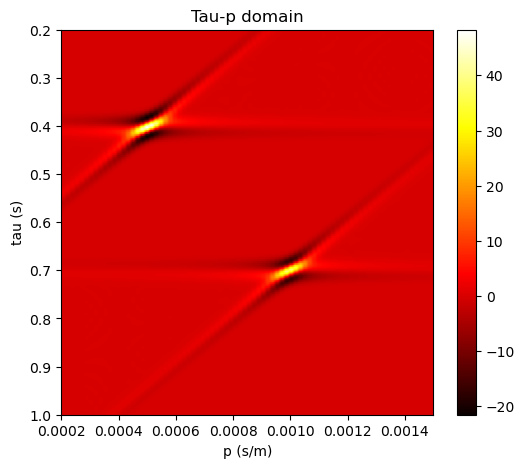

In [34]:
# see what happens
plt.figure(figsize=(6,5))
plt.imshow(
    tau_p.T,
    extent=[p_vals[0], p_vals[-1], tau_vals[-1], tau_vals[0]],
    aspect='auto',
    cmap='hot'
)
plt.xlabel("p (s/m)")
plt.ylabel("tau (s)")
plt.title("Tau-p domain")
plt.colorbar()
plt.show()

How to understand the result:

$p$ 为速度的倒数（$t-x$ 图上的斜率），两个波表示了两个理想的爆炸事件，其传播速度不同，即斜率 $p$ 不同。在 $x-t$ 域上，两个波以不同位置、不同时间的振幅来刻画，而在 $\tau-p$ 域上则以“发生时刻” $\tau$ 和“速度”（倒数形式）$p$ 刻画。

## Read data example

### Read segy data

.segy 数据分为两部分：数据和header。

对于数据部分，其为一个 [n_traces * n_samples] 的大矩阵/tensor。
- n_traces 维度表示某一次爆炸（shot）、某一个传感器的数据记录，总长度等于爆炸数*传感器数
- n_samples 维度表示根据某一个频率采样一段时间得到的振幅，总长度等于采样频率*采样时间

对于header部分，其分为 binary header（整个数据共有的）和 trace header（每条trace可能都不同）
对于binary header，重要的key：
- Interval：采样间隔（单位一般是微秒）

其为 n_traces 个字典，用来保存每一个trace的元信息。
这个字典很大，有很多key，但重要的key只有几个：
- TraceNumber：检波器/水听器/传感器 编号。这个数据集里一共有120个传感器，从1编到120；传感器间隔可以通过下面的GroupX推断出来，应该是25。
- FieldRecord：shot编号，表示第几次爆炸，非常重要，因为不同爆炸的trace没有什么对比意义。这个数据集里一共有1001次爆炸，从3编号到1003。
- SourceX, SourceY: 震源位置坐标。基本只有SourceX在变。可以发现这个坐标是以传感器数量为周期变化的。
- GroupX, GroupY: 检波器/水听器/传感器 位置坐标。可以发现这个坐标是以传感器数量为周期变化的，且同一个传感器，下一次的位置会相对上一次有所偏移（船在动）。
- Offset: 源-传感器 距离
- CDP: 反射点编号？

In [12]:
filename = "/Users/ziyezhang/dataset/seismic.segy"

# Read .segy file
with segyio.open(filename, "r", ignore_geometry=True) as f:
    # data
    print("ilines:", f.ilines)
    print("xlines:", f.xlines)
    print("offsets:", f.offsets)
    print("n_traces:", f.tracecount)
    print("n_samples:", len(f.samples))
    f.trace.raw[:].shape  #[n_traces, n_samples]
    data = f.trace.raw[:]  # array[n_traces, n_samples]

    # header
    ## binary header
    bh = f.bin
    print(bh[segyio.BinField.Interval])   # 微秒
    binary_header = bh

    ## trace header
    trace_id = 0
    h = f.header[trace_id]  # 第trace_id个trace的header信息，最大是trace_id最大是n_traces-1
    for k, v in h.items():
        print(k, v)

    # save all header to csv
    headers = []
    for trace_id in range(f.tracecount):
        headers.append(f.header[trace_id])

df = pd.DataFrame(headers)

ilines: None
xlines: None
offsets: None
n_traces: 120120
n_samples: 1500
4000
TRACE_SEQUENCE_LINE 1
TRACE_SEQUENCE_FILE 1
FieldRecord 3
TraceNumber 1
EnergySourcePoint 101
CDP 1
CDP_TRACE 1
TraceIdentificationCode 1
NSummedTraces 0
NStackedTraces 1
DataUse 0
offset -3237
ReceiverGroupElevation -10
SourceSurfaceElevation -6
SourceDepth 0
ReceiverDatumElevation 0
SourceDatumElevation 0
SourceWaterDepth 0
GroupWaterDepth 0
ElevationScalar 1
SourceGroupScalar 1
SourceX 3237
SourceY 0
GroupX 0
GroupY 0
CoordinateUnits 3
WeatheringVelocity 0
SubWeatheringVelocity 0
SourceUpholeTime 0
GroupUpholeTime 0
SourceStaticCorrection 0
GroupStaticCorrection 0
TotalStaticApplied 0
LagTimeA 0
LagTimeB 0
DelayRecordingTime 0
MuteTimeStart 0
MuteTimeEND 48
TRACE_SAMPLE_COUNT 1500
TRACE_SAMPLE_INTERVAL 4000
GainType 0
InstrumentGainConstant 0
InstrumentInitialGain 0
Correlated 0
SweepFrequencyStart 0
SweepFrequencyEnd 0
SweepLength 0
SweepType 0
SweepTraceTaperLengthStart 0
SweepTraceTaperLengthEnd 0
Taper

In [13]:
print(type(data))
print(data.shape)

<class 'numpy.ndarray'>
(120120, 1500)


In [14]:
# 取出一条道
data_0 = data[0:120, :]

# 由于 data_0 的顺序是由远及近排列的，我们需要将其反转
data_0 = data_0[::-1, :]

In [15]:
data_0.shape

(120, 1500)

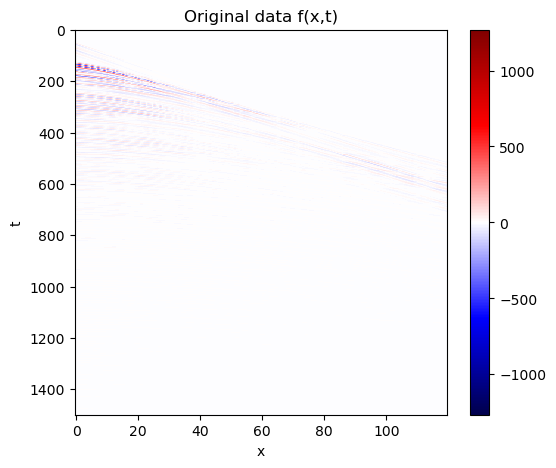

In [17]:
plt.figure(figsize=(6,5))
plt.imshow(
    data_0.T,
    aspect='auto',
    cmap='seismic'
)
plt.xlabel("x")
plt.ylabel("t")
plt.title("Original data f(x,t)")
plt.colorbar()
plt.show()


### $\tau-p$ transform


In [18]:
# tau 和 p 的采样点
p_vals = np.linspace(0.0002, 0.0015, 80)
tau_vals = np.linspace(0.2, 1.0, 200)

tau_p = np.zeros((len(p_vals), len(tau_vals)))

Discrete $\tau-p$ transform: 
$$D(\tau,p)=\sum_{x} f(x,\tau+ px)$$

In [27]:
# basic parameters
Nx = data_0.shape[0]
Nt = data_0.shape[1]
dx = 25        # m
dt = 0.004     # s

x = np.arange(Nx) * dx
t = np.arange(Nt) * dt

# tau-p transform
for ip, p in enumerate(p_vals):
    for itau, tau in enumerate(tau_vals):
        stack = 0.0

        for ix in range(Nx):
            t_sample = tau + p * x[ix]

            if t_sample < t[0] or t_sample > t[-1]:
                continue

            # 对时间插值（这是 τ–p 的灵魂）
            interp = interp1d(t, data[ix], kind='linear')
            stack += interp(t_sample)

        tau_p[ip, itau] = stack


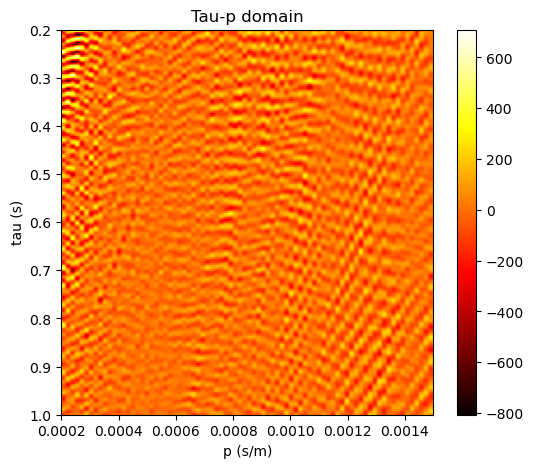

In [28]:
# see what happens
plt.figure(figsize=(6,5))
plt.imshow(
    tau_p.T,
    extent=[p_vals[0], p_vals[-1], tau_vals[-1], tau_vals[0]],
    aspect='auto',
    cmap='hot'
)
plt.xlabel("p (s/m)")
plt.ylabel("tau (s)")
plt.title("Tau-p domain")
plt.colorbar()
plt.show()
